# Transfer Learning

There are significant benefits to using a pretrained model. It reduces computation costs, your carbon footprint, and allows you to use state-of-the-art models without having to train one from scratch. Even better, you can train it on a dataset specific to your task by utilizing transfer learning or fine-tuning, two incredibly powerful training techniques.

The general idea of transfer learning is to use knowledge learned from tasks for which a lot of labelled data is available in settings where only little labelled data is available. Creating labelled data is expensive, so optimally leveraging existing datasets is key. 

Transfer learning usually involves replacing the last layer of a NN and optimize only this. If you have more training data you can also replace/optimize the last few layers. This way you don’t need to optimize all the parameters of your NN and can focus on optimizing only the parameters of the replaced layers with your training data.

Transfer learning makes sense when:

- There is a lot of  training data for a general problem and only a little data for a spcific problem
  
- The general problem has the same input data as a specific problem
  
- Low-level features of a general problem are relevan for high-level features of a specific problem

The most common incarnation of transfer learning in the context of deep learning is the following workflow:

1. Take layers from a previously trained model.
   
2. Freeze them, so as to avoid destroying any of the information they contain during future training rounds.
   
3. Add some new, trainable layers on top of the frozen layers. They will learn to turn the old features into predictions on a new dataset.
   
4. Train the new layers on your dataset.

A last, optional step, is **fine-tuning**, which consists of unfreezing the entire model you obtained above (or part of it), and re-training it on the new data with a very low learning rate. This can potentially achieve meaningful improvements, by incrementally adapting the pretrained features to the new data.

The key differences between fine-tuning and transfer learning is that:

- **Training Approach:** In transfer learning, we freeze all the pre-trained layers and only train the new layers added on top. In fine-tuning, we unfreeze some of the pre-trained layers and allow them to be updated during training.
  
- **Computational Resources:** Transfer learning requires fewer computational resources since only the new layers are trained. Fine-tuning, on the other hand, may require more resources, especially if we unfreeze and update a significant number of pre-trained layers.
  
- **Training Time:** Transfer learning generally requires less training time since we are training fewer parameters. Fine-tuning may take longer, especially if we are updating a larger number of pre-trained layers.
  
- **Dataset Size:** Transfer learning is effective when the new dataset is small, as it leverages the pre-trained model’s knowledge on a large dataset. Fine-tuning is more suitable for larger datasets, as it allows the model to learn more specific features related to the new task.

## Packages

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

## Freezing layers: understanding the trainable attribute

Layers & models have three weight attributes:

- weights is the list of all weights variables of the layer.
- trainable_weights is the list of those that are meant to be updated (via gradient descent) to minimize the loss during training.
- non_trainable_weights is the list of those that aren't meant to be trained. Typically they are updated by the model during the forward pass.

Example: the Dense layer has 2 trainable weights (kernel & bias)

In [2]:
layer = keras.layers.Dense(3)
layer.build((None, 4))  # Create the weights

print("weights:", len(layer.weights))
print("trainable_weights:", len(layer.trainable_weights))
print("non_trainable_weights:", len(layer.non_trainable_weights))

weights: 2
trainable_weights: 2
non_trainable_weights: 0


Layers & models also feature a boolean attribute `trainable`. Its value can be changed. Setting layer.trainable to False moves all the layer's weights from trainable to non-trainable. This is called "freezing" the layer: the state of a frozen layer won't be updated during training (either when training with fit() or when training with any custom loop that relies on trainable_weights to apply gradient updates).

In [3]:
layer = keras.layers.Dense(3)
layer.build((None, 4))  # Create the weights
layer.trainable = False  # Freeze the layer

print("weights:", len(layer.weights))
print("trainable_weights:", len(layer.trainable_weights))
print("non_trainable_weights:", len(layer.non_trainable_weights))

weights: 2
trainable_weights: 0
non_trainable_weights: 2


In general, all weights are trainable weights. The only built-in layer that has non-trainable weights is the `BatchNormalization` layer. It uses non-trainable weights to keep track of the mean and variance of its inputs during training. 

In [4]:
layer = keras.layers.BatchNormalization()
layer.build((None, 4))  # Create the weights

print("weights:", len(layer.weights))
print("trainable_weights:", len(layer.trainable_weights))
print("non_trainable_weights:", len(layer.non_trainable_weights))

weights: 4
trainable_weights: 2
non_trainable_weights: 2


When a trainable weight becomes non-trainable, its value is no longer updated during training.

In [5]:
# Make a model with 2 layers
layer1 = keras.layers.Dense(3, activation="relu")
layer2 = keras.layers.Dense(3, activation="sigmoid")
model = keras.Sequential([keras.Input(shape=(3,)), layer1, layer2])

# Freeze the first layer
layer1.trainable = False

# Keep a copy of the weights of layer1 for later reference
initial_layer1_weights_values = layer1.get_weights()

# Train the model
model.compile(optimizer="adam", loss="mse")
model.fit(np.random.random((2, 3)), np.random.random((2, 3)))

# Check that the weights of layer1 have not changed during training
final_layer1_weights_values = layer1.get_weights()
print(initial_layer1_weights_values[0],'\n---------\n', final_layer1_weights_values[0])
print('*****************')
np.testing.assert_allclose(
    initial_layer1_weights_values[0], final_layer1_weights_values[0]
)

print(initial_layer1_weights_values[1],'\n', final_layer1_weights_values[1])
np.testing.assert_allclose(
    initial_layer1_weights_values[1], final_layer1_weights_values[1]
)

1/1 [==============================] - 2s 2s/step - loss: 0.1886
[[ 0.57523966 -0.47607422 -0.32641578]
 [ 0.8462255  -0.27996325  0.57728934]
 [ 0.6482005  -0.5565698  -0.00737429]] 
---------
 [[ 0.57523966 -0.47607422 -0.32641578]
 [ 0.8462255  -0.27996325  0.57728934]
 [ 0.6482005  -0.5565698  -0.00737429]]
*****************
[0. 0. 0.] 
 [0. 0. 0.]


## Recursive setting of the `trainable` attribute

If you set trainable = False on a model or on any layer that has sublayers, all children layers become non-trainable as well.

In [6]:
inner_model = keras.Sequential(
    [
        keras.Input(shape=(3,)),
        keras.layers.Dense(3, activation="relu"),
        keras.layers.Dense(3, activation="relu"),
    ]
)

model = keras.Sequential(
    [
        keras.Input(shape=(3,)),
        inner_model,
        keras.layers.Dense(3, activation="sigmoid"),
    ]
)

model.trainable = False  # Freeze the outer model

print('inner_model.trainable', inner_model.trainable)
assert inner_model.trainable == False  # All layers in `model` are now frozen

print("inner_model.layers[0].trainable", inner_model.layers[0].trainable)
assert inner_model.layers[0].trainable == False  # `trainable` is propagated recursively

inner_model.trainable False
inner_model.layers[0].trainable False


## The typical transfer-learning workflow

1. Instantiate a base model and load pre-trained weights into it.
2. Freeze all layers in the base model by setting `trainable = False`.
3. Create a new model on top of the output of one (or several) layers from the base model.
4. Train your new model on your new dataset.

An alternative, more lightweight workflow could also be:

1. Instantiate a base model and load pre-trained weights into it.
2. Run your new dataset through it and record the output of one (or several) layers from the base model. This is called **feature extraction.**
3. Use that output as input data for a new, smaller model.

A key advantage of that second workflow is that you only run the base model once on your data, rather than once per epoch of training. So it's a lot faster & cheaper. 

However, an issue with that second workflow, though, is that it doesn't allow you to dynamically modify the input data of your new model during training, which is required when doing data augmentation, for instance.Transfer learning is typically used for tasks when your new dataset has too little data to train a full-scale model from scratch, and in such scenarios data augmentation is very important.

Let's go through this workflow:

First, instantiate a base model with pre-trained weights.

In [7]:
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

This is the architectures of the **Xception model**, however it is not of particular importance for us right now. It is only important to know that it is used for image classfication and was trained on ImageNet

<img src="images/xception model.png">

In [8]:
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 74, 74, 32)   864         ['input_4[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 74, 74, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                           

Then, freeze the base model.

In [16]:
base_model.trainable = False

Create a new model on top.

In [17]:
inputs = keras.Input(shape=(150, 150, 3))

# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(inputs, training=False)

# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)

# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

Train the model on new data.


In [11]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])
model.fit(new_dataset, epochs=20, validation_data=...)

NameError: name 'new_dataset' is not defined

### Important note about `compile()` and trainable

Calling `compile()` on a model is meant to "freeze" the behavior of that model. This implies that the `trainable` attribute values at the time the model is compiled should be preserved throughout the lifetime of that model, until `compile` is called again. Hence, if you change any trainable value, make sure to call `compile()` again on your model for your changes to be taken into account.

### Important notes about BatchNormalization layer

Many image models contain BatchNormalization layers. That layer is a special case on every imaginable count. Here are a few things to keep in mind.

- `BatchNormalization` contains 2 non-trainable weights that get updated during training. These are the variables tracking the mean and variance of the inputs.
  
- When you set `bn_layer.trainable = False`, the `BatchNormalization` layer will run in inference mode, and will not update its mean & variance statistics. This is not the case for other layers in general, as weight trainability & inference/training modes are two orthogonal concepts. But the two are tied in the case of the `BatchNormalization` layer.
  
- When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, you should keep the `BatchNormalization` layers in inference mode by passing training=False when calling the base model. Otherwise the updates applied to the non-trainable weights will suddenly destroy what the model has learned.

# End-to-End Example

To solidify the concepts, let's walk through an end-to-end example of transfer learning and fine-tuning example. We will load the **Xception model**, pretrained on ImageNet, and use it on the small alpaca dataset provided. 

## 1. Load Dataset

When training and evaluating deep learning models in Keras, generating a dataset from image files stored on disk is simple and fast. Call `image_data_set_from_directory()` to read from the directory and create both training and validation datasets. 

If you're specifying a validation split, you'll also need to specify the subset for each portion. Just set the training set to `subset='training'` and the validation set to `subset='validation'`.

You'll also set your seeds to match each other, so your training and validation sets don't overlap. :) 

## IMPORTANT: RESTART KERNEL BEFORE YOU CONTINUE

In [18]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [19]:
BATCH_SIZE = 32
IMG_SIZE = (150, 150)
SEED = 7
directory = "dataset/"
train_dataset = keras.preprocessing.image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=SEED)

validation_dataset = keras.preprocessing.image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=SEED)

Found 327 files belonging to 2 classes.
Using 262 files for training.
Found 327 files belonging to 2 classes.
Using 65 files for validation.


### Visualize the data
Here are the first nine images from the training dataset.

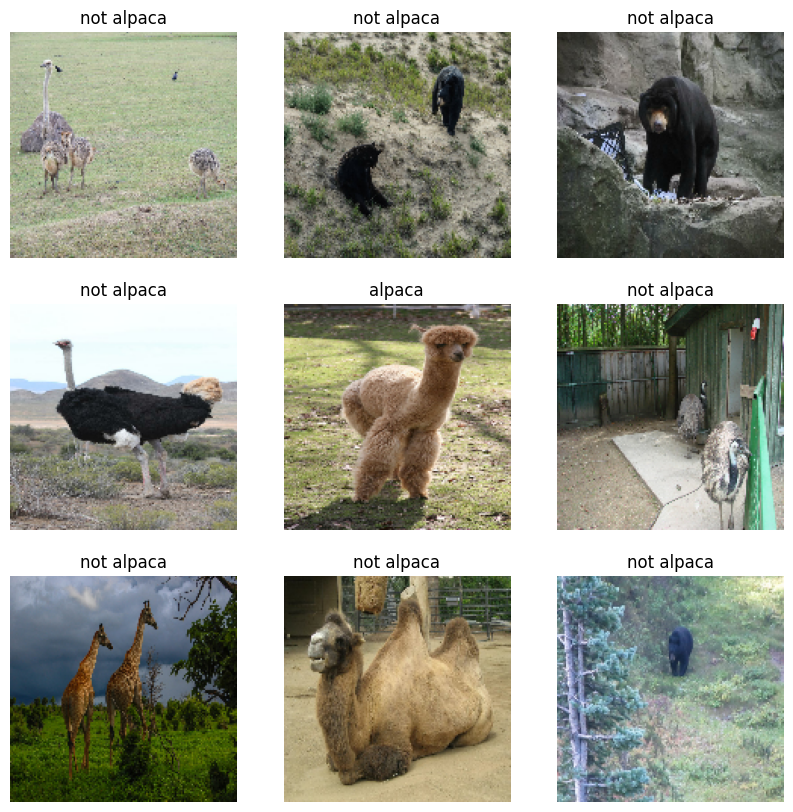

In [20]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## 2. Preprocessing and Augmenting the Training data

Using `prefetch()` prevents a memory bottleneck that can occur when reading from disk. It sets aside some data and keeps it ready for when it's needed, by creating a source dataset from your input data, applying a transformation to preprocess it, then iterating over the dataset one element at a time. Because the iteration is streaming, the data doesn't need to fit into memory.

You can set the number of elements to prefetch manually, or you can use `tf.data.experimental.AUTOTUNE` to choose the parameters automatically. Autotune prompts `tf.data` to tune that value dynamically at runtime, by tracking the time spent in each operation and feeding those times into an optimization algorithm. The optimization algorithm tries to find the best allocation of its CPU budget across all tunable operations. 

In [21]:
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

### Augmentation

To increase diversity in the training set and help your model learn the data better, it's standard practice to augment the images by transforming them, i.e., randomly flipping and rotating them. Keras' Sequential API offers a straightforward method for these kinds of data augmentations, with built-in, customizable preprocessing layers. These layers are saved with the rest of your model and can be re-used later.

In [22]:
def data_augmenter():
    '''
    Create a Sequential model composed of 2 layers
    Returns:
        tf.keras.Sequential
    '''
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(keras.layers.RandomFlip('horizontal', seed=SEED))
    data_augmentation.add(keras.layers.RandomRotation(0.2, seed=SEED))
    
    return data_augmentation

Take a look at how an image from the training set has been augmented with simple transformations:

From one picture, to 9 variations of that animal, in three lines of code. Now your model has a lot more to learn from.

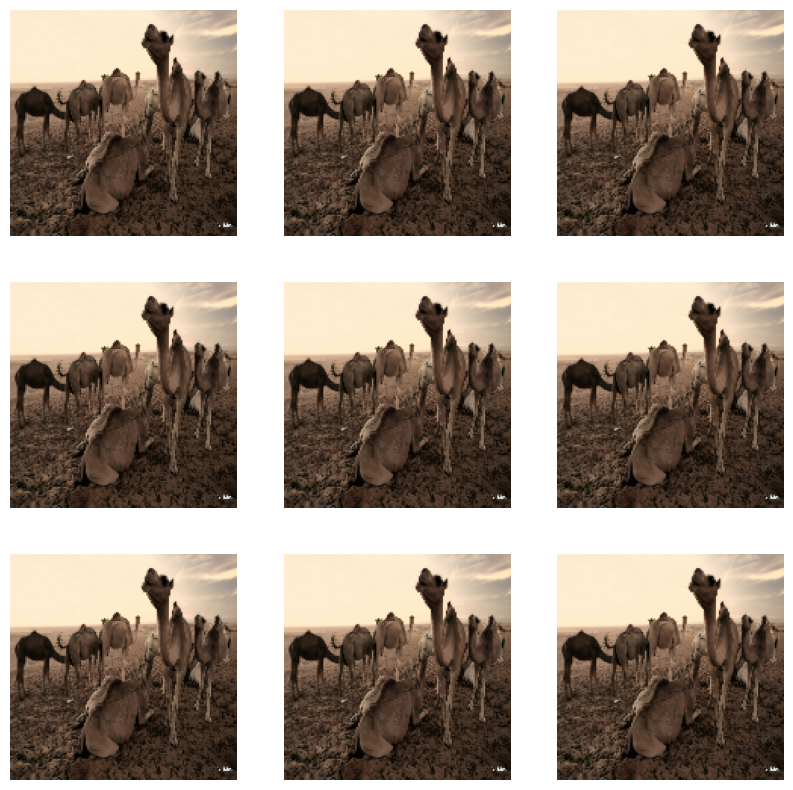

In [23]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0]/255)
        plt.axis('off')

Next, you'll apply your first tool from the Xception application in TensorFlow, to normalize our input. Since we're using a pre-trained model that was trained on the normalization values [-1,1], it's best practice to reuse that standard.

In other words, Pre-trained Xception weights requires that input be scaled from (0, 255) to a range of (-1., +1.)

In [78]:
preprocess_input = keras.applications.xception.preprocess_input

## Build a model

Now let's built a model that follows the blueprint we've explained earlier.

Note:
- We add a Dropout layer before the classification layer, for regularization.
- We make sure to pass `training=False` when calling the base model, so that it runs in inference mode, so that batchnorm statistics don't get updated even after we unfreeze the base model for fine-tuning.

In [61]:
def alpaca_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    ''' 
    Defines a tf.keras model for binary classification out of the Xception model
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
    Returns:
    Returns:
        tf.keras.model
    '''
    
    input_shape = image_shape + (3, )
    
    # get the base model which was trained on ImageNet
    base_model = keras.applications.Xception(
        input_shape = input_shape,
        include_top=False, # Important
        weights = "imagenet"
    )
    
    # Freeze the base model to make the layers non trainable
    base_model.trainable = False
    
    # Create an input layer with the same shape as ImageNetv2 input size
    inputs = keras.Input(shape=input_shape)
    
    # apply the augmentation to the inputs
    x = data_augmentation(inputs)
    
    # preprocess the data to be within range (-1, +1)
    x = preprocess_input(x)
    
    # set training to False avoid keeping track of statistics in the batch norm layer
    # This is a very important step otherwise the model understanding of the features will be destroyed
    x = base_model(x, training=False)
    
    # Add a global average pooling layer to summariuze the info in each channel
    x = keras.layers.GlobalAveragePooling2D()(x) 
    
    # Add dropout with probability 0.2 to avoid overfitting
    x = keras.layers.Dropout(0.2)(x)
    
    # Add a binary classification layer
    # Use a prediction layer with one neuron
    outputs = keras.layers.Dense(1)(x)
    
    model = keras.Model(inputs, outputs)
    
    return model

Create a new model

In [62]:
tl_model = alpaca_model(IMG_SIZE, data_augmentation)

In [63]:
tl_model.summary(show_trainable=True)

Model: "model_3"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_11 (InputLayer)       [(None, 150, 150, 3)]     0         Y          
                                                                            
 sequential_7 (Sequential)   (None, 150, 150, 3)       0         Y          
                                                                            
 tf.math.truediv_2 (TFOpLamb  (None, 150, 150, 3)      0         Y          
 da)                                                                        
                                                                            
 tf.math.subtract_2 (TFOpLam  (None, 150, 150, 3)      0         Y          
 bda)                                                                       
                                                                            
 xception (Functional)       (None, 5, 5, 2048)        2086

Compile the model

In [64]:
base_learning_rate = 0.001
tl_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [65]:
initial_epochs = 5
history = tl_model.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/5


9/9 [==============================] - 15s 502ms/step - loss: 0.7473 - accuracy: 0.5458 - val_loss: 0.5192 - val_accuracy: 0.6923
Epoch 2/5
9/9 [==============================] - 3s 342ms/step - loss: 0.5948 - accuracy: 0.6412 - val_loss: 0.4184 - val_accuracy: 0.7846
Epoch 3/5
9/9 [==============================] - 3s 347ms/step - loss: 0.5244 - accuracy: 0.7214 - val_loss: 0.3676 - val_accuracy: 0.8462
Epoch 4/5
9/9 [==============================] - 3s 364ms/step - loss: 0.4525 - accuracy: 0.7176 - val_loss: 0.3469 - val_accuracy: 0.8154
Epoch 5/5
9/9 [==============================] - 3s 331ms/step - loss: 0.4022 - accuracy: 0.7672 - val_loss: 0.3332 - val_accuracy: 0.8615


### Plot the Accuracy

<Axes: >

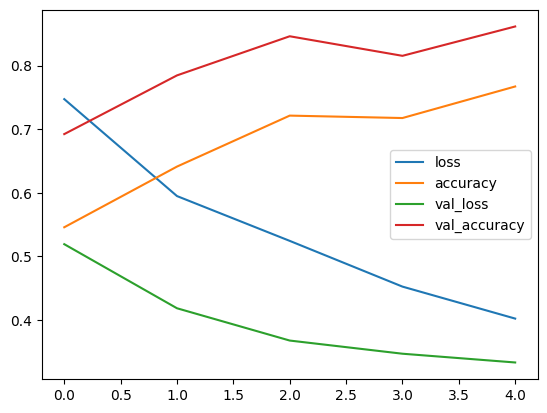

In [66]:
import pandas as pd
results = pd.DataFrame(history.history)
results.plot()

The results are ok, just with replacing the top layer. Now, let's try to make them better using fine-tuning

## Finetuning

Once your model has converged on the new data, you can try to unfreeze all or part of the base model and retrain the whole model end-to-end with a very low learning rate.

This is an optional last step that can potentially give you incremental improvements. It could also potentially lead to quick overfitting – keep that in mind.

The intuition for what's happening: when the network is in its earlier stages, it trains on low-level features, like edges. In the later layers, more complex, high-level features like wispy hair or pointy ears begin to emerge. For transfer learning, the low-level features can be kept the same, as they have common features for most images. When you add new data, you generally want the high-level features to adapt to it, which is rather like letting the network learn to detect features more related to your data, such as soft fur or big teeth. 

It is critical to only do this step after the model with frozen layers has been trained to convergence. If you mix randomly-initialized trainable layers with trainable layers that hold pre-trained features, the randomly-initialized layers will cause very large gradient updates during training, which will destroy your pre-trained features.

It's also critical to use a very low learning rate at this stage, because you are training a much larger model than in the first round of training, on a dataset that is typically very small. As a result, you are at risk of overfitting very quickly if you apply large weight updates. Here, you only want to readapt the pretrained weights in an incremental way.

In [67]:
# Get Xception base model
base_model = tl_model.layers[4]

# make it trainable
base_model.trainable = True

# Let's take a look to see the number of layers in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# lets fine tune from layer 100 onwards
fine_tune_at = 110

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Number of layers in the base model:  132


In [68]:
tl_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 sequential_7 (Sequential)   (None, 150, 150, 3)       0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 150, 150, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 150, 150, 3)      0         
 bda)                                                            
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d_3   (None, 2048)             0   

In [69]:
tl_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1*base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [70]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = tl_model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 5/10


9/9 [==============================] - 12s 517ms/step - loss: 0.4143 - accuracy: 0.7634 - val_loss: 0.3270 - val_accuracy: 0.8615
Epoch 6/10
9/9 [==============================] - 3s 369ms/step - loss: 0.3095 - accuracy: 0.8626 - val_loss: 0.2476 - val_accuracy: 0.8923
Epoch 7/10
9/9 [==============================] - 3s 359ms/step - loss: 0.2678 - accuracy: 0.8435 - val_loss: 0.3376 - val_accuracy: 0.9077
Epoch 8/10
9/9 [==============================] - 3s 352ms/step - loss: 0.1333 - accuracy: 0.9618 - val_loss: 0.3335 - val_accuracy: 0.8769
Epoch 9/10
9/9 [==============================] - 3s 361ms/step - loss: 0.1497 - accuracy: 0.9542 - val_loss: 0.3683 - val_accuracy: 0.8923
Epoch 10/10
9/9 [==============================] - 3s 352ms/step - loss: 0.0975 - accuracy: 0.9542 - val_loss: 0.4869 - val_accuracy: 0.9077


In [71]:
acc = [0.] + history.history['accuracy'] + history_fine.history['accuracy']
val_acc = [0.] + history.history['val_accuracy'] + history_fine.history['val_accuracy']

loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

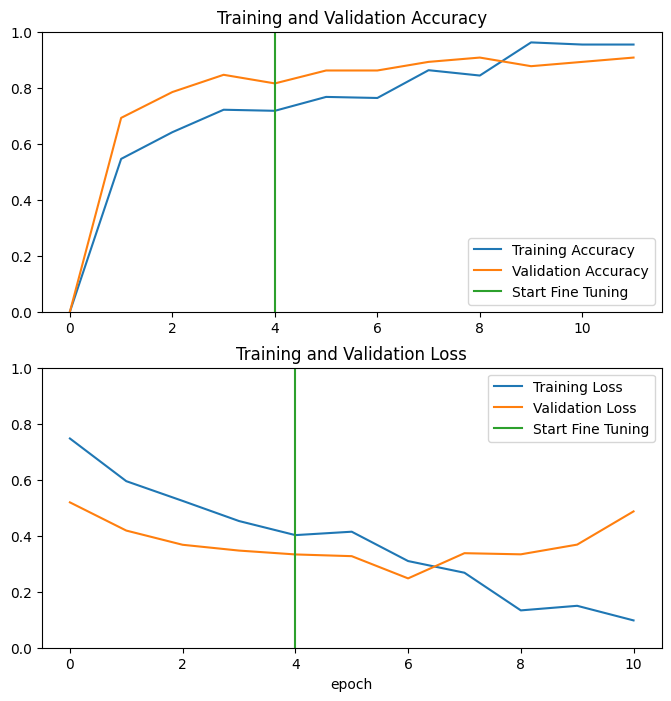

In [72]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Congratulations!

You have fine-tuned a model on your custom dataset